## 1. Imports

In [2]:
import os, sys
sys.path.append("..")

import wandb
import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.light_sb import LightSB

from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
    get_test_input_samples
)

from eot_benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, compute_BW_by_gt_samples, calculate_cond_bw
)

## 2. Config

In [3]:
DIM = 2
assert DIM > 1

SEED = 42
BATCH_SIZE = 128
EPSILON = 10
D_LR = 6e-2 # 1e-3 for eps 0.1, 3e-3 for eps 1, 6e-2 for eps 10
# ALPHA_LR = 1e-2
D_GRADIENT_MAX_NORM = float("inf")
N_POTENTIALS = 50
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

MAX_STEPS = 10000
CONTINUE = -1

In [4]:
torch.manual_seed(SEED); np.random.seed(SEED)

In [5]:
EXP_NAME = f'EOT_benchmark_EPSILON_{EPSILON}_DIM_{DIM}_SEED_{SEED}'
OUTPUT_PATH = '../checkpoints/{}'.format(EXP_NAME)

config = dict(
    DIM=DIM,
    D_LR=D_LR,
    BATCH_SIZE=BATCH_SIZE,
    EPSILON=EPSILON,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    N_POTENTIALS=N_POTENTIALS,
    INIT_BY_SAMPLES=INIT_BY_SAMPLES,
    SEED=SEED,
)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## 3. Initialize Benchmark

In [6]:
X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPSILON,
                                           batch_size=BATCH_SIZE, device=f"cpu", download=True)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPSILON,
                                          batch_size=BATCH_SIZE, device=f"cpu", download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPSILON,
                                                                                batch_size=BATCH_SIZE, 
                                                                                device=f"cpu",
                                                                                download=False)

Downloading...
From (original): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
From (redirected): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY&confirm=t&uuid=8528c82b-9713-4bce-96d6-3cb00725dd43
To: C:\Users\georg\eot_benchmark_data\gaussian_mixture_benchmark_data.zip
100%|██████████| 84.8M/84.8M [00:04<00:00, 19.5MB/s]


In [7]:
pca = PCA(n_components=2)

samples = X_sampler.sample(10000)
samples = samples.cpu()

target_samples = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

pca.fit(target_samples)

PCA(n_components=2)

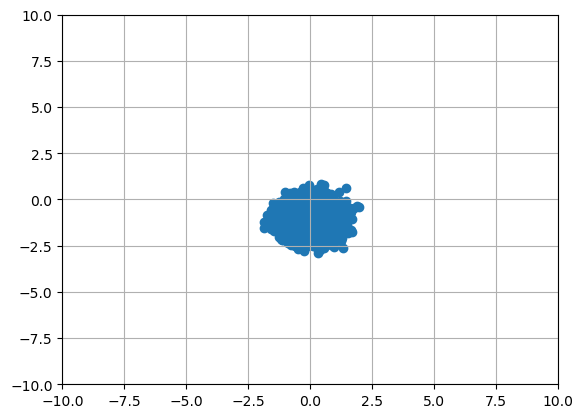

In [8]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()

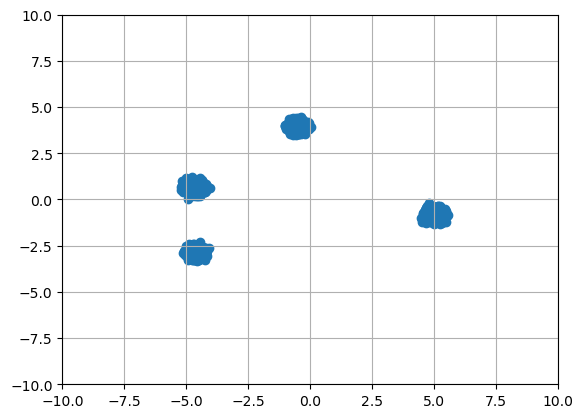

In [9]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()

## 4. Model initialization

In [10]:
D = LightSB(dim=DIM, n_potentials=N_POTENTIALS, epsilon=EPSILON,
            sampling_batch_size=SAMPLING_BATCH_SIZE, is_diagonal=IS_DIAGONAL, S_diagonal_init=1.0)

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))

D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)

In [14]:
def pca_plot(x_0_gt, x_1_gt, x_1_pred, n_plot, step):
    fig,axes = plt.subplots(1, 3,figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    pca = PCA(n_components=2).fit(x_1_gt)
    
    x_0_gt_pca = pca.transform(x_0_gt[:n_plot])
    x_1_gt_pca = pca.transform(x_1_gt[:n_plot])
    x_1_pred_pca = pca.transform(x_1_pred[:n_plot])
    
    axes[0].scatter(x_0_gt_pca[:,0], x_0_gt_pca[:,1], c="g", edgecolor = 'black',
                    label = r'$x\sim P_0(x)$', s =30)
    axes[1].scatter(x_1_gt_pca[:,0], x_1_gt_pca[:,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =30)
    axes[2].scatter(x_1_pred_pca[:,0], x_1_pred_pca[:,1], c="yellow", edgecolor = 'black',
                    label = r'$x\sim T(x)$', s =30)
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-10, 10])
        axes[i].set_ylim([-10, 10])
        axes[i].legend()
    
    fig.tight_layout(pad=0.5)

def plot_mapping(independent_mapping, true_mapping, predicted_mapping, target_data, n_plot, step):
    s=30
    linewidth=0.2
    map_alpha=1
    data_alpha=1
    figsize=(5, 5)
    dpi=None
    data_color='red'
    mapped_data_color='blue'
    map_color='green'
    map_label=None
    data_label=None
    mapped_data_label=None
    
    dim = target_data.shape[-1]
    pca = PCA(n_components=2).fit(target_data)
    
    independent_mapping_pca = np.concatenate((        
        pca.transform(independent_mapping[:n_plot, :dim]),
        pca.transform(independent_mapping[:n_plot, dim:]),
        ), axis=-1)
 
    true_mapping_pca = np.concatenate((
        pca.transform(true_mapping[:n_plot, :dim]),
        pca.transform(true_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    predicted_mapping_pca = np.concatenate((
        pca.transform(predicted_mapping[:n_plot, :dim]),
        pca.transform(predicted_mapping[:n_plot, dim:]),
    ), axis=-1)
    
    target_data_pca = pca.transform(target_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    titles = ["independent", "true", "predicted"]
    for i, mapping in enumerate([independent_mapping_pca, true_mapping_pca, predicted_mapping_pca]):
        inp = mapping[:, :2]
        out = mapping[:, 2:]

        lines = np.concatenate([inp, out], axis=-1).reshape(-1, 2, 2)
        lc = matplotlib.collections.LineCollection(
            lines, color=map_color, linewidths=linewidth, alpha=map_alpha, label=map_label)
        axes[i].add_collection(lc)

        axes[i].scatter(
            inp[:, 0], inp[:, 1], s=s, label=data_label,
            alpha=data_alpha, zorder=2, color=data_color)
        axes[i].scatter(
            out[:, 0], out[:, 1], s=s, label=mapped_data_label,
            alpha=data_alpha, zorder=2, color=mapped_data_color)

        axes[i].scatter(target_data_pca[:1000,0], target_data_pca[:1000,1], c="orange", edgecolor = 'black',
                    label = r'$x\sim P_1(x)$', s =10)
        axes[i].grid()
        axes[i].set_title(titles[i])
    

    
    
def pca_plot_plan(independent_plan, true_plan, predicted_plan, n_plot, step):
    fig,axes = plt.subplots(1, 3,figsize=(12,4),squeeze=True,sharex=True,sharey=True)
    pca = PCA(n_components=2).fit(true_plan)
    
    predicted_plan_pca = pca.transform(predicted_plan[:n_plot])
    true_plan_pca = pca.transform(true_plan[:n_plot])
    independent_plan_pca = pca.transform(independent_plan[:n_plot])
    
    axes[0].scatter(independent_plan_pca[:,0], independent_plan_pca[:,1], c="g", edgecolor = 'black',
                    label = r'Independent plan', s =30)
    axes[1].scatter(true_plan_pca[:,0], true_plan_pca[:,1], c="orange", edgecolor = 'black',
                    label = r'True plan', s =30)
    axes[2].scatter(predicted_plan_pca[:,0], predicted_plan_pca[:,1], c="yellow", edgecolor = 'black',
                    label = r'Predicted plan', s =30)
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-10, 10])
        axes[i].set_ylim([-10, 10])
        axes[i].legend()
    
    fig.tight_layout(pad=0.5)

## 5. Model training

100%|██████████| 1000/1000 [00:33<00:00, 29.47it/s]


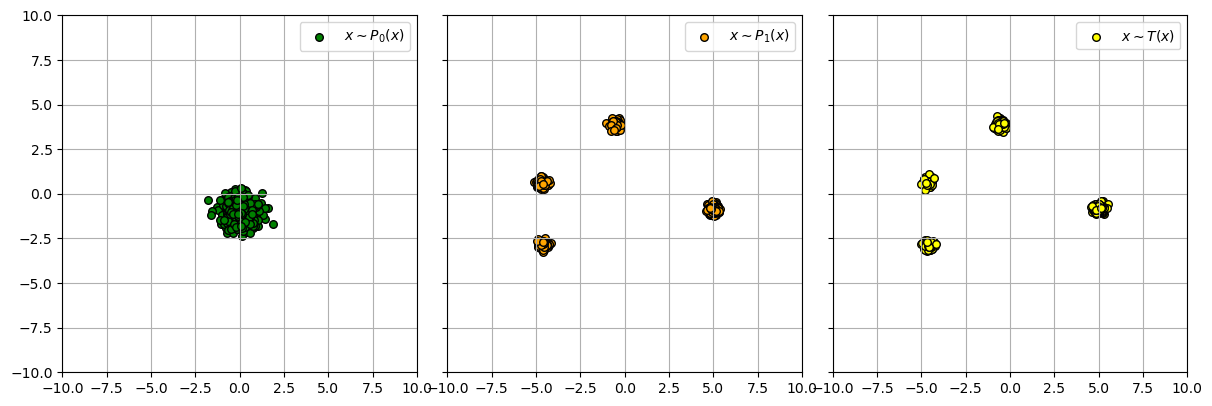

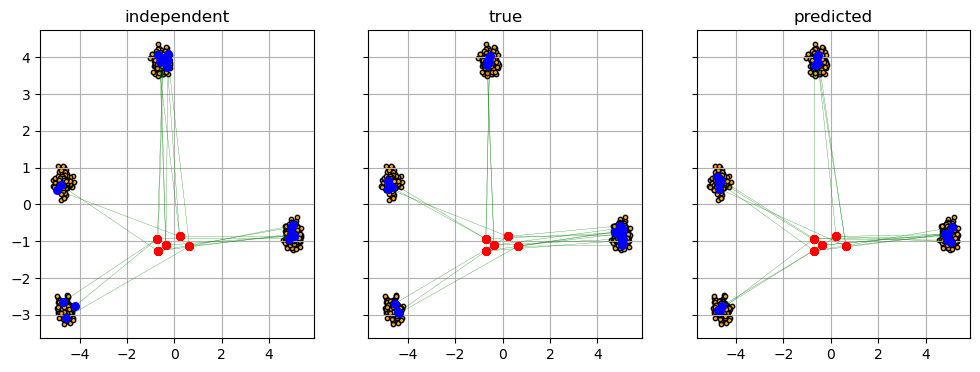

In [16]:
# wandb.init(name=EXP_NAME, config=config)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    # training cycle
    D_opt.zero_grad()
    
    X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
    
    log_potential = D.get_log_potential(X1)
    log_C = D.get_log_C(X0)
    
    D_loss = (-log_potential + log_C).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step()
    
    # wandb.log({f'D gradient norm' : D_gradient_norm.item()}, step=step)
    # wandb.log({f'D_loss' : D_loss.item()}, step=step)
    
# plotting and evaluating
with torch.no_grad():
# bw-uvp
    X = X_sampler.sample(100000).cpu()
    Y = Y_sampler.sample(100000).cpu()

    XN = D(X)

    X0_gt, XN_gt = ground_truth_plan_sampler.sample(20)

    bw_uvp_target = compute_BW_UVP_by_gt_samples(XN.cpu().numpy(), Y.cpu().numpy())

    pca_plot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(),
         XN.detach().cpu().numpy(), n_plot=500, step=step)

    # calculate cond_bw
    test_samples = get_test_input_samples(dim=DIM, device="cpu")

    model_input = test_samples.reshape(1000, 1, -1).repeat(1, 1000, 1)
    predictions = []
    for inp in tqdm(model_input):
        predictions.append(D(inp))

    predictions = torch.stack(predictions, dim=0)

    # calculate cond_bw new
    new_cond_bw = calculate_cond_bw(test_samples, predictions, eps=EPSILON, dim=DIM)

    X_repeated = X0_gt[:5].repeat(20, 1)
    Y_true_mapped = ground_truth_plan_sampler.conditional_plan.sample(X_repeated)

    X_repeated = X_repeated.cpu()
    Y_true_mapped = Y_true_mapped.cpu()

    true_plan = torch.cat((X_repeated, Y_true_mapped), dim=-1)
    independent_plan = torch.cat((X_repeated, Y[:100]), dim=-1)
    predicted_plan = torch.cat((X_repeated, D(X_repeated)), dim=-1)

    plot_mapping(independent_plan.detach().cpu().numpy(), true_plan.detach().cpu().numpy(),
             predicted_plan.detach().cpu().numpy(), Y.detach().cpu().numpy(),
                 n_plot=20, step=step)

    # wandb.log({f'BW-UVP_target' : bw_uvp_target}, step=step)
    # wandb.log({f'new_cond_bw' : new_cond_bw}, step=step)
    #         
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D.pt'))
torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'D_opt.pt'))

# wandb.finish()